# Grafici Trasmittanza Spettrofotometro


In [7]:
import Functions_Tries.plotter as plotter
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
from Functions_Tries.transmittance import Transmittance
from pathlib import Path
# import logging as lg

# lg.basicConfig(filename='bog.log',filemode='w')
# logger = lg.getLogger()
# logger.setLevel(lg.DEBUG)


plt.style.use("seaborn")

C:\Users\ginob\AppData\Local\Temp\ipykernel_800\4154301503.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# Il codice seguente serve al fit dello spessore dagli spettri ottenuti dallo spettrofotometro

- Usiamo la libreria ```numpy``` per avere la matematica corretta e dei contenitori efficenti.
- Usiamo la libreria ```scipy.interpolate``` per avere le curve di Bezier per interpolare i dati ottenuti dal Johnson
- Usiamo la libreria ```scipy.optimize``` per fittare gli spettri e ottenere il valore di spessore e l'errore
- Usiamo la libreria ```pandas``` per leggere i file che contengono gli spettri e per l'output
- Stefano ha scritto il modulo ```transmittance``` per avere le funzioni su cui fare il fit e per fare il primo test di fattibilità sui fit
- Usiamo il modulo ```pathlib``` per gestire i Path dei vari file in maniera automatizzata
- Usiamo la libreria ```matplotlib``` per graficare gli spettri

## TODO

- [ ] Aggiungere il salvataggio di tutti i risultati su un file
- [ ] Fare i grafici automatici, salvandoli in una cartella separata Graph

In [8]:
# Imposto la precisione per l'output dei numeri
np.set_printoptions(precision=2)

# Path entro cui fare le ricerche
dir = Path("./data/")

# Nome colonne for pretty printing
colonne = ["NomeFile", "ValoreFit", "ErrFit", "χ_2_Rid", "GdL"]

# Liste vuote, servono per salvare i vari dati del fit
data_Beer_Lambert = dict(
    NomeFile = [],
    ValoreFit = [],
    ErrFit = [],
    χ_2_Rid = [],
    GdL = []
)

data_Transmittance = dict(
    NomeFile = [],
    ValoreFit = [],
    ErrFit = [],
    χ_2_Rid = [],
    GdL = []
)

data_Transmittance_n_free = dict(
    NomeFile = [],
    ValoreFit = [],
    ErrFit = [],
    n_obt = [],
    err_n = [],
    χ_2_Rid = [],
    GdL = []
)


# leggo dati del johnny
john = pd.read_csv("./data/book_data/Johnson.csv")
n_spl_john = CubicSpline(john["wl"], john["n"])
k_spl_john = CubicSpline(john["wl"], john["k"])

# Inizializziamo la classe che contiene le transmittance per i successivi fit
Trans = Transmittance(
    n=n_spl_john, 
    # n=1, 
    k=k_spl_john, 
    n_0=1., 
    n_1=1.52
    )


# Funzione che va a fare i fit in maniera automatica a partire dai dati ottenuti per beer lambert...
# Purtroppo per non avere troppo sbatti copio e incollo questa funzione e sostituisco con transmittance
def optimizer_beer_lambert(path: Path, dest_name = None):
    # Leggiamo i dati
    df = pd.read_csv(path)
    # Ci sono capitati dati uguali a zero... questi creano problemi, via dal dataframe
    # Revisione successiva introduce delle condizioni più strette... I dati che si possono usare sono quelli che
    # sono maggiori di 0 e minori di 1... Le altre condizioni sono solo spiacevoli infortuni.
    df_clean = df[(df["polished"] > 0) & (df["polished"] < 1.)]
    
    # Filtro per le lunghezze d'onda
    filter_λ = (df_clean["lambda"] < 800e-9) & (df_clean["lambda"] > 300e-9)

    # Calcoliamo l'errore secondo quanto dichiarato dalla macchina (3 % sulla misura)
    sigma = df_clean[filter_λ]["polished"] * 0.3 / 100

    # Calcoliamo lo spessore e il suo errore
    popt, pcov = curve_fit(
        Trans.beer_lambert,
        df_clean[filter_λ]["lambda"],
        df_clean[filter_λ]["polished"],
        p0=60e-9,
        sigma=sigma,
    )
    
    # Calcolo del Chi quadro... Potrebbe essere inserito nel grafico, ma non ho voglia
    chisq_rid = np.sum(
                    (df_clean[filter_λ]["polished"] - Trans.beer_lambert(df_clean[filter_λ]["lambda"], *popt))** 2
                    / sigma**2
                ) / df_clean[filter_λ].size
    
    # Grafichiamo... Innanzitutto controlliamo se c'è la directory dove buttare fuori i dati
    # Se non ci fosse la creiamo, ho recentemente scoperto che si può fare tutto in un solo comando
    if dest_name == None:
        dest = Path("./images/beer_lambert/" + path.parent.parts[-2])
        dest.mkdir(parents=True, exist_ok=True)
    # questo serve solo nel caso in cui sia lanciato iteratore_spettro()
    else:
        dest = Path("./images/beer_lambert/").joinpath(dest_name[0]+'/'+dest_name[1])
        # Quello che è contenuto in join path serve ad aggiugnere *_spettrofotometro/vetrino_*
        # Nella mia stanchezza non mi è venuto in mente niente di meglio... 
        dest.mkdir(parents=True, exist_ok=True)

    # Ora Grafichiamo
    fig, ax = plt.subplots()
    # Aggiungiamo i dati, ho riscalato le misure per avere sull'asse x dei nm e non dei metri illeggibili
    # Dati originali
    ax.plot(
        df_clean[filter_λ]["lambda"] * 1e9,
        df_clean[filter_λ]["polished"],
        "go",
        label="original data",
    )
    # La funzione fittata
    ax.plot(
        df_clean[filter_λ]["lambda"] * 1e9,
        Trans.beer_lambert(df_clean[filter_λ]["lambda"], *popt),
        label=f"fit : {popt*1e9} nm",
    )
    # Questioni estetiche relative agli assi
    ax.set_xlabel("$\\lambda$ [nm]")
    ax.set_ylabel("Transmittance")
    ax.set_title("Fit Beer Lambert")
    ax.legend()
    # Salviamo l'immagine, sia in formato svg che in formato pdf...
    fig.savefig(dest / path.with_suffix(".svg").name, format="svg")
    fig.savefig(dest / path.with_suffix(".pdf").name, format="pdf")
    fig.savefig(dest / path.with_suffix(".png").name, format="png")
    # Per qualche motivo non resetta i canvas... lo forziamo a pulirsi
    plt.clf()
    plt.cla()
    plt.close()
    
    # Riportiamo finalmente i risulati, in ordine sono il parametro ottimizzato, il suo errore,
    # il chi quadro ridotto, i gradi di libertà
    return popt, np.sqrt(np.diag(pcov)), chisq_rid, df_clean[filter_λ].size

def optimizer_transmittance(path: Path, dest_name = None):
    # Leggiamo i dati
    df = pd.read_csv(path)
    # Ci sono capitati dati uguali a zero... questi creano problemi, via dal dataframe
    # Revisione successiva introduce delle condizioni più strette... I dati che si possono usare sono quelli che
    # sono maggiori di 0 e minori di 1... Le altre condizioni sono solo spiacevoli infortuni.
    df_clean = df[(df["polished"] > 0) & (df["polished"] < 1.)]
    # Filtro per le lunghezze d'onda
    filter_λ = (df_clean["lambda"] < 800e-9) & (df_clean["lambda"] > 300e-9)
    # Calcoliamo l'errore secondo quanto dichiarato dalla macchina (3 % sulla misura)
    sigma = df_clean[filter_λ]["polished"] * 0.3 / 100

    # Calcoliamo lo spessore e il suo errore
    popt, pcov = curve_fit(
        Trans.transmittance,
        df_clean[filter_λ]["lambda"],
        df_clean[filter_λ]["polished"],
        p0=60e-9,
        sigma=sigma,
    )
    # Grafichiamo... Innanzitutto controlliamo se c'è la directory dove buttare fuori i dati
    # Se non ci fosse la creiamo, ho recentemente scoperto che si può fare tutto in un solo comando
    if dest_name == None:
        dest = Path("./images/transmittance/" + path.parent.parts[-2])
        dest.mkdir(parents=True, exist_ok=True)
    # questo serve solo nel caso in cui sia lanciato iteratore_spettro()
    else:
        dest = Path("./images/transmittance/").joinpath(dest_name[0]+'/'+dest_name[1])
        # Quello che è contenuto in join path serve ad aggiugnere *_spettrofotometro/vetrino_*
        # Nella mia stanchezza non mi è venuto in mente niente di meglio... 
        dest.mkdir(parents=True, exist_ok=True)

    # Ora Grafichiamo
    fig, ax = plt.subplots()
    # Aggiungiamo i dati, ho riscalato le misure per avere sull'asse x dei nm e non dei metri illeggibili
    # Dati originali
    ax.plot(
        df_clean[filter_λ]["lambda"] * 1e9,
        df_clean[filter_λ]["polished"],
        "go",
        label="original data",
    )
    # La funzione fittata
    ax.plot(
        df_clean[filter_λ]["lambda"] * 1e9,
        Trans.transmittance(df_clean[filter_λ]["lambda"], *popt),
        label=f"fit : {popt*1e9} nm",
    )
    # Questioni estetiche relative agli assi
    ax.set_xlabel("$\\lambda$ [nm]")
    ax.set_ylabel("Transmittance")
    ax.set_title("Fit Trasmittanza")
    ax.legend()
    # Salviamo l'immagine, sia in formato svg che in formato pdf...
    fig.savefig(dest / path.with_suffix(".svg").name, format="svg")
    fig.savefig(dest / path.with_suffix(".pdf").name, format="pdf")
    fig.savefig(dest / path.with_suffix(".png").name, format="png")
    # Per qualche motivo non resetta i canvas... lo forziamo a pulirsi
    plt.clf()
    plt.cla()
    plt.close()
    # Calcolo del Chi quadro... Potrebbe essere inserito nel grafico, ma non ho voglia
    chisq_rid = np.sum(
                    (df_clean[filter_λ]["polished"] - Trans.transmittance(df_clean[filter_λ]["lambda"], *popt))** 2
                    / sigma**2
                ) / df_clean.size
    # Riportiamo finalmente i risulati, in ordine sono il parametro ottimizzato, il suo errore,
    # il chi quadro ridotto, i gradi di libertà
    return popt, np.sqrt(np.diag(pcov)), chisq_rid, df_clean.size

def optimizer_transmittance_n_free(path: Path, dest_name = None):
    # Leggiamo i dati
    df = pd.read_csv(path)
    # Ci sono capitati dati uguali a zero... questi creano problemi, via dal dataframe
    # Revisione successiva introduce delle condizioni più strette... I dati che si possono usare sono quelli che
    # sono maggiori di 0 e minori di 1... Le altre condizioni sono solo spiacevoli infortuni.
    df_clean = df[(df["polished"] > 0) & (df["polished"] < 1.)]
    # Filtro per le lunghezze d'onda
    filter_λ = (df_clean["lambda"] < 800e-9) & (df_clean["lambda"] > 300e-9)
    # Calcoliamo l'errore secondo quanto dichiarato dalla macchina (3 % sulla misura)
    sigma = df_clean[filter_λ]["polished"] * 0.3 / 100

    # Calcoliamo lo spessore e il suo errore
    popt, pcov = curve_fit(
        Trans.transmittance_n_free,
        df_clean[filter_λ]["lambda"],
        df_clean[filter_λ]["polished"],
        p0=[1.51, 60e-9],
        sigma=sigma,
    )
    # Grafichiamo... Innanzitutto controlliamo se c'è la directory dove buttare fuori i dati
    # Se non ci fosse la creiamo, ho recentemente scoperto che si può fare tutto in un solo comando
    if dest_name == None:
        dest = Path("./images/transmittance_n_free/" + path.parent.parts[-2])
        dest.mkdir(parents=True, exist_ok=True)
    # questo serve solo nel caso in cui sia lanciato iteratore_spettro()
    else:
        dest = Path("./images/transmittance_n_free/").joinpath(dest_name[0]+'/'+dest_name[1])
        # Quello che è contenuto in join path serve ad aggiugnere *_spettrofotometro/vetrino_*
        # Nella mia stanchezza non mi è venuto in mente niente di meglio... 
        dest.mkdir(parents=True, exist_ok=True)

    # Ora Grafichiamo
    fig, ax = plt.subplots()
    # Aggiungiamo i dati, ho riscalato le misure per avere sull'asse x dei nm e non dei metri illeggibili
    # Dati originali
    ax.plot(
        df_clean[filter_λ]["lambda"] * 1e9,
        df_clean[filter_λ]["polished"],
        "go",
        label="original data",
    )
    # La funzione fittata
    ax.plot(
        df_clean[filter_λ]["lambda"] * 1e9,
        Trans.transmittance_n_free(df_clean[filter_λ]["lambda"], *popt),
        label=f"fit : {popt[1]*1e9} nm,\n n_1 : {popt[0]}",
    )
    # Questioni estetiche relative agli assi
    ax.set_xlabel("$\\lambda$ [nm]")
    ax.set_ylabel("Transmittance")
    ax.set_title("Fit Trasmittanza, indice di rifrazione libero")
    ax.legend()
    # Salviamo l'immagine, sia in formato svg che in formato pdf...
    fig.savefig(dest / path.with_suffix(".svg").name, format="svg")
    fig.savefig(dest / path.with_suffix(".pdf").name, format="pdf")
    fig.savefig(dest / path.with_suffix(".png").name, format="png")
    # Per qualche motivo non resetta i canvas... lo forziamo a pulirsi
    plt.clf()
    plt.cla()
    plt.close()
    # Calcolo del Chi quadro... Potrebbe essere inserito nel grafico, ma non ho voglia
    chisq_rid = np.sum(
                    (df_clean[filter_λ]["polished"] - Trans.transmittance_n_free(df_clean[filter_λ]["lambda"], *popt))** 2
                    / sigma**2
                ) / df_clean.size
    # Riportiamo finalmente i risulati, in ordine sono il parametro ottimizzato, il suo errore,
    # il chi quadro ridotto, i gradi di libertà
    return popt, np.sqrt(np.diag(pcov)), chisq_rid, df_clean.size


# Funzione per salvare dati, in questo modo non dobbiamo ogni volta riscrivere lo stesso codice 2 volte
def saving_beer_lambert(file, i = None):
    # Ottengo i risultati dell'ottimizzatore e li carico in un Liste a parte
    if i == None:
        res = optimizer_beer_lambert(file)
    else:
        # Questo lo uso quando capita iteratore_spettro... che è un filo più rompiballe
        res = optimizer_beer_lambert(file, [i.parts[-3], i.parts[-2]])
    
    # Pretty Printing
    # new_row = pd.Series([file, *res], index=colonne)
    # print(new_row)

    # SALVATAGGIO DATI
    data_Beer_Lambert["NomeFile"].append(file)
    data_Beer_Lambert["ValoreFit"].append(float(res[0])) # Secondo me è un qualcosa di brutto quel cast a float
    data_Beer_Lambert["ErrFit"].append(float(res[1])) # Ma non mi è venuto in mente niente di meglio per risolvere la questione
    data_Beer_Lambert["χ_2_Rid"].append(res[2])
    data_Beer_Lambert["GdL"].append(res[3])

def saving_transmittance(file, i = None):
    # Ottengo i risultati dell'ottimizzatore e li carico in un Liste a parte
    if i == None:
        res = optimizer_transmittance(file)
    else:
        # Questo lo uso quando capita iteratore_spettro... che è un filo più rompiballe
        res = optimizer_transmittance(file, [i.parts[-3], i.parts[-2]])
    
    # Pretty Printing
    # new_row = pd.Series([file, *res], index=colonne)
    # print(new_row)

    # SALVATAGGIO DATI
    data_Transmittance["NomeFile"].append(file)
    data_Transmittance["ValoreFit"].append(float(res[0])) # Secondo me è un qualcosa di brutto quel cast a float
    data_Transmittance["ErrFit"].append(float(res[1])) # Ma non mi è venuto in mente niente di meglio per risolvere la questione
    data_Transmittance["χ_2_Rid"].append(res[2])
    data_Transmittance["GdL"].append(res[3])

def saving_transmittance_n_free(file, i = None):
    # Ottengo i risultati dell'ottimizzatore e li carico in un Liste a parte
    if i == None:
        res = optimizer_transmittance_n_free(file)
    else:
        # Questo lo uso quando capita iteratore_spettro... che è un filo più rompiballe
        res = optimizer_transmittance_n_free(file, [i.parts[-3], i.parts[-2]])
    
    # Pretty Printing
    # new_row = pd.Series([file, *res], index=colonne)
    # print(new_row)

    # SALVATAGGIO DATI
    data_Transmittance_n_free["NomeFile"].append(file)
    data_Transmittance_n_free["ValoreFit"].append(float(res[0][1])) # Secondo me è un qualcosa di brutto quel cast a float
    data_Transmittance_n_free["ErrFit"].append(float(res[1][1])) # Ma non mi è venuto in mente niente di meglio per risolvere la questione
    data_Transmittance_n_free["n_obt"].append(float(res[0][0]))
    data_Transmittance_n_free["err_n"].append(float(res[1][0]))
    data_Transmittance_n_free["χ_2_Rid"].append(res[2])
    data_Transmittance_n_free["GdL"].append(res[3])



# Funzione che itera su tutti i file contenuti nella cartella "./data"
def iterazione(path):
    # Ci interessano solo le cartelle che contengono la parola spettrofotometro
    data = [i for i in path.iterdir() if i.match("*spettrofotometro")] # purtroppo per filtrare non abbiamo ancora scoperto un modo migliore...
                                                                       # Così non posso sfruttare i vantaggi dei generatori
    for i in data:
        # Itero solo sulle sottocartelle e non su file che sono in giro
        subfolder = [j for j in i.iterdir() if j.is_dir()]
        for folder in subfolder:
            # Dobbiamo trovarci nella cartella ELAB per fare qualsiasi cosa
            if folder.match("ELAB"):
                # Itero sui file di ELAB
                for file in folder.iterdir():
                    # Piccole correzioni per evitare di fare Step inutili
                    if file.match("*.png"):
                        continue
                    if file.match("Aria*") or file.match("aria*") or file.match("air*"):
                        continue
                    saving_beer_lambert(file)
                    saving_transmittance(file)
                    saving_transmittance_n_free(file)
            else:
                # Ci sono cartelle che contengono spettrofotometro... Ma hanno sottocartelle sottostanti
                # print("La cartella non è Elab... gestiamo logica dopo")
                # print(folder)
                iterazione_spettro(folder)


# In alcuni casi non si trova subito la cartella "ELAB", in quei casi bisogna scendere ancora di un livello
def iterazione_spettro(path):
    # print("launching iterazione_spettro")
    # print(path)
    elab = [i for i in path.iterdir() if i.match("ELAB")]
    # print(elab)
    for i in elab:
        for file in i.iterdir():
            if file.match("*.png"):
                continue
            if file.match("Aria*") or file.match("aria*") or file.match("air*"):
                continue
            # Beer Lambert
            saving_beer_lambert(file, i=i)
            saving_transmittance(file, i=i)
            saving_transmittance_n_free(file, i=i)

# Finalmente lanciamo la cazzo di funzione
iterazione(dir)

# SALVATAGGIO DATI BEER LAMBERT SU FILE
res_df_beer_lambert = pd.DataFrame(data_Beer_Lambert)
res_df_beer_lambert.to_csv("Risultati_Beer_Lambert_spettrofotometro.csv", index=False)

# SALVATAGGIO DATI TRANSMITTANCE SU FILE
res_transmittance = pd.DataFrame(data_Transmittance)
res_df_beer_lambert.to_csv("Risultati_Transmittance_spettrofotometro.csv", index=False)

res_transmittance_n_free = pd.DataFrame(data_Transmittance_n_free)
res_transmittance_n_free.to_csv("Risultati_Transmittance_n_free_spettrofotometro.csv", index=False)


c:\Users\ginob\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\ginob\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\ginob\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\ginob\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\ginob\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters coul

# C'era qualcosa che non funzionava

Piccolo test via via che beccavamo qualcosa che non funzionava per capire da dove venisse l'errore.

In [9]:
import Functions_Tries.Spectrofotometer_Thickness

# Immagini dello spettrofotometro, 26 Maggio

In [10]:
dfs = []

for file in Path("data/26-05_spettrofotometro/ELAB/").iterdir():
    if file.match("Oro*"):
        dfs.append([pd.read_csv(file), file])

In [11]:
dfs

[[            lambda  transmittance  polished  trasm_error
  0     9.000000e-07         0.8200  0.290091     0.001741
  1     8.995000e-07         0.8218 -2.017182    -0.012103
  2     8.990000e-07         0.8021 -2.715301    -0.016292
  3     8.985000e-07         0.8229  0.354057     0.002124
  4     8.980000e-07         0.8267  0.189254     0.001136
  ...            ...            ...       ...          ...
  1096  3.520000e-07         1.0116  0.865133     0.005191
  1097  3.515000e-07         1.0117  0.862710     0.005176
  1098  3.510000e-07         1.0158  0.856492     0.005139
  1099  3.505000e-07         1.0142  0.870184     0.005221
  1100  3.500000e-07         1.0190  0.880726     0.005284
  
  [1101 rows x 4 columns],
  PosixPath('data/26-05_spettrofotometro/ELAB/Oro7b_Aria_1.csv')],
 [            lambda  transmittance  polished  trasm_error
  0     9.000000e-07         0.2056  0.072735     0.000436
  1     8.995000e-07         0.1972 -0.484045    -0.002904
  2     8.990000e-

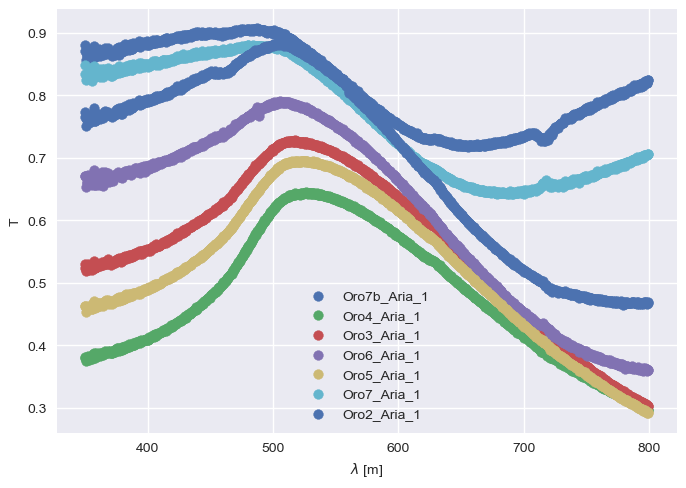

In [14]:
fig, ax = plt.subplots()
for df in dfs:
    name = df[1].stem
    data = df[0]
    data = data[data["lambda"]<800e-9]
    ax.scatter( data["lambda"]*1e9, data["polished"], label=str(name))

ax.set_xlabel("$\\lambda$ [m]")
ax.set_ylabel("T")
ax.set_title("Transmittance with various thicknesses")
ax.legend()
